# Exemplary constellation plots
## Supplementary Information for the paper: "Finding constellations in chemical space through core analysis" in Frontiers in Chemistry
### J. Jesús Naveja, José L. Medina-Franco
#### contact: naveja@comunidad.unam.mx
#### May 3rd 2019
In this notebook, obtention of constellation plots is demonstrated for a library of Akt inhibitors, and another of DNMT inhibitors. 

NOTE 1: the final figures in the manuscript were produced in LATEX using the data obtained by running the code in this notebook.

NOTE 2: prior to running this notebook, databases have to be curated and processed with the get-cores.py program, which is used to identify cores.

## 0. Preamble: import libraries and define functions

In [1]:
from rdkit.Chem import AllChem
from rdkit import Chem
from IPython.display import SVG, clear_output

from sklearn.manifold import TSNE
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil, sqrt
from itertools import combinations
from scripts.Rtables import Rcore

In [2]:
def tsneFP(df, cmpid, fingerprint = "Morgan",perplexity=40, n_iter = 3000, minimum_size = 2):
    '''
    function for computing fingerprints for a library of molecules and applying t-SNE for dimensionality 
    reduction
    ----------
    input:
    df: a pandas dataframe
    cmpid: a string matching the column name where the IDs of compounds is saved
    fingerprint: a string, either "Morgan" or "MACCS" for selecting a fingerprint type
    perplexity and n_iter are parameters of the TSNE function from scikit-learn
    minimum_size: the smallest size of analog series to consider
    -------
    output:
    final df: an object containing the following attributes:
    "cores": a dataframe with the information per core
    "chemical space": the result of the t-SNE algorithm required for visualization
    "edges": the connections among cores
    '''
    # remove duplicated cores by compounds
    hashes = df["cores"].groupby("core").WID.apply(lambda x: str(sorted(set(x))))
    hashdf = pd.DataFrame({"core": hashes.index, "hash": hashes.values})
    hashdf['HA'] = hashdf.core.map(lambda x: Chem.MolFromSmiles(x).GetNumHeavyAtoms())

    proc = list()

    for duphash in hashes[hashes.duplicated()].unique():
        tmp = hashdf[hashdf.hash == duphash].copy()
        tmp.sort_values(by= "HA", ascending=False, inplace=True)
        proc.append(tmp.core.iloc[0])
    
    final = proc + list(hashes[hashes.isin(hashes[hashes.duplicated()].unique()) == False].index)
    
    df["cores"] = df["cores"][df["cores"].core.isin(final)]
    
    #count series size
    
    corecount = df["cores"][["core", "WID"]].drop_duplicates().core.value_counts() 
    corecount = corecount[corecount >= minimum_size]

    coredf = pd.DataFrame({"core": corecount.index, "series_size": corecount.values})
    
    if fingerprint == "Morgan":
        coredf["FP"] = coredf.core.map(lambda x: AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x),2, nBits=1024))
    elif fingerprint == "MACCS":
        coredf["FP"] = coredf.core.map(lambda x: AllChem.GetMACCSKeysFingerprint(Chem.MolFromSmiles(x)))
    else:
        print("Fingerprint: '{}' is currently not implemented".format(fingerprint))
        
    tmp = list()
    for i in coredf.FP.iteritems():
        tmp.append(list(i[1].ToBitString()))
    tmp = np.array(tmp).astype(int)
    
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(tmp)
        
    newdf = coredf.copy()
    newdf['xtsne'] = tsne_results[:,0]
    newdf['ytsne'] = tsne_results[:,1]
    
    finaldf = df.copy()
    
    finaldf["chemspace"] = newdf.drop(columns="FP")
    
    finaldf["chemspace"] = finaldf["chemspace"].merge(finaldf["cores"][["core", "MID"]].drop_duplicates(), on="core").merge(finaldf["ASM"][["MID", "ASID"]], on="MID")
    
    #ASID
    astol = pd.DataFrame({"ASID": finaldf["chemspace"].ASID.unique()})
    astol["newASID"] = range(1, len(astol)+1)
    finaldf["chemspace"] =finaldf["chemspace"].merge(astol, on="ASID")
    
    #Get edges
    cores = finaldf["chemspace"].MID
    coremol = finaldf["cores"][finaldf["cores"].MID.isin(cores)][[cmpid, "MID"]].drop_duplicates()
    
    dups = coremol[cmpid][coremol[cmpid].duplicated()].unique()
    
    combs = set()
    for dup in dups:
        mids = set(coremol.MID[coremol[cmpid] == dup])
        combs= combs.union({i for i in combinations(mids,2)})
    combs = list(combs)
    
    finaldf["edges"] = combs
    
    return finaldf 

In [3]:
def cplot(preobj, alpha=1, sfactor= 4, col = None, collabel = None, zoom=None):
    '''
    function for generating a constellation plot
    --------------
    input: 
    preobj: the object obtained as a result of the tsneFP function
    alpha: float, transparency of points
    sfactor: float, size of dots
    col: Boolean, whether a color will be added to the plot
    collabel: string, column containing color attribute 
    zoom: 4-duple containing x1,x2,y1,y2 of two points to frame an area
    -----------------
    output:
    fig: the resulting plot
    obj: the resulting object (relevant if the zoom option is used)
    '''
    fig, ax = plt.subplots()
    
    obj = preobj.copy()
    
    if zoom:
        x1,x2,y1,y2=zoom
        obj["chemspace"] = obj["chemspace"][(obj["chemspace"].xtsne >= x1) & (obj["chemspace"].xtsne <= x2) &
                                           (obj["chemspace"].ytsne >= y1) & (obj["chemspace"].ytsne <= y2)]
        
        obj["edges"] = [(i,j) for i,j in obj["edges"] if (i in list(obj["chemspace"].MID.values)) & (j in list(obj["chemspace"].MID.values))]
    
    if col:
        im=ax.scatter(obj["chemspace"].xtsne, obj["chemspace"].ytsne, alpha=1, c=obj["chemspace"][col], cmap="jet", s= sfactor*obj["chemspace"].series_size)
        fig.colorbar(im,label=collabel)

    else:
        im=ax.scatter(obj["chemspace"].xtsne, obj["chemspace"].ytsne, alpha=1, cmap="jet", s= sfactor*obj["chemspace"].series_size)

    for i,j in obj["edges"]:
        i = obj["chemspace"][obj["chemspace"].MID == i][["xtsne", "ytsne"]].iloc[0]
        j = obj["chemspace"][obj["chemspace"].MID == j][["xtsne", "ytsne"]].iloc[0]
        plt.plot([i[0], j[0]], [i[1], j[1]], 'k-', alpha=alpha)
        
    return fig, obj

In [4]:
def nmols(obj, cmpid):
    '''
    Function for describing the size of the dataset 
    -------------
    input:
    obj: the object resulting from applying the tsneFP function
    cmpid: the name of the column containing the compound IDs
    -------------
    output:
    None. A string is print on the console
    '''
    print("Number of cores: {}, molecules: {}, AS: {}".format(len(obj["chemspace"]), 
                                                              len(obj["cores"][obj["cores"].core.isin(obj["chemspace"].core)][cmpid].unique()),
                                                             len(obj["chemspace"].ASID.unique())))

## 2. Read data

In [5]:
dnmt = {i: pd.read_csv("cores_dnmt" + i + ".tsv", sep="\t") for i in ["ASW", "ASM", "cores"]}
akt = {i: pd.read_csv("cores_akt" + i + ".tsv", sep="\t") for i in ["ASW", "ASM", "cores"]}

## 3. Analysis of DNMT database

In [436]:
dnmt = tsneFP(dnmt, perplexity=10, cmpid= "SBSMID") #apply t-SNE with default Morgan FP

[t-SNE] Computing 22 nearest neighbors...
[t-SNE] Indexed 23 samples in 0.000s...
[t-SNE] Computed neighbors for 23 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 23 / 23
[t-SNE] Mean sigma: 3.434263
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.499695
[t-SNE] KL divergence after 2350 iterations: 0.110186


In [317]:
nmols(dnmt, "SBSMID")#print information

Number of cores: 23, molecules: 46, AS: 13


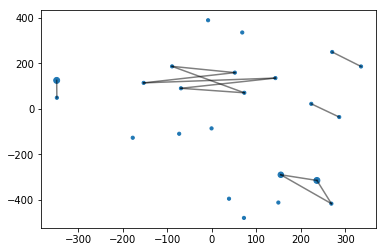

In [437]:
f=cplot(dnmt, alpha=.5, sfactor=5)#plot constellation plot. Note: results may vary in different iterations

### 3.1 Adding activity data

In [441]:
dnmtact = pd.DataFrame(dnmt["cores"].groupby(["MID","Unigene"]).active.apply(lambda x: sum(x) / len(x))).unstack(level = 1).active.fillna(-1)

dnmt["chemspace"] = dnmt["chemspace"].merge(dnmtact, on = "MID")

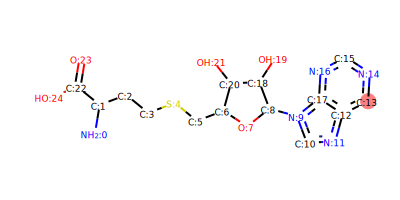

In [609]:
#visualize one core, for example: M14
m = "M14"
core = dnmt["chemspace"].core[dnmt["chemspace"].MID == m].values[0]
analogs = dnmt["cores"].washed[dnmt["cores"].MID == m]
analogs.index = dnmt["cores"].WID[dnmt["cores"].MID == m]

Rcore(core, analogs)[0]

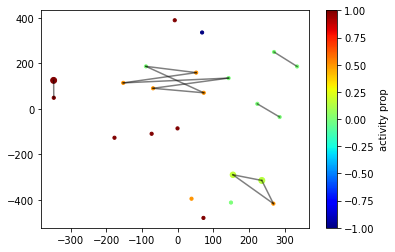

In [443]:
f=cplot(dnmt, alpha=.5, sfactor=5, col = "DNMT1", collabel="activity prop") #plot constellation plot with activities for DNMT1

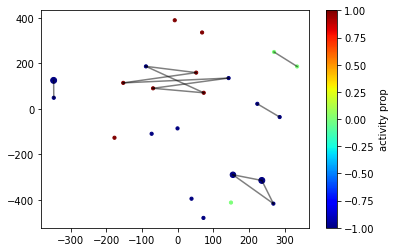

In [444]:
f=cplot(dnmt, alpha=.5, sfactor=5, col = "DNMT3A", collabel="activity prop")#plot constellation plot with activities for DNMT3A

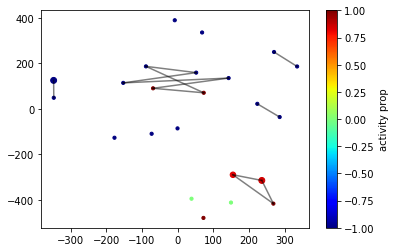

In [445]:
f=cplot(dnmt, alpha=.5, sfactor=5, col = "DNMT3B", collabel="activity prop")#plot constellation plot with activities for DNMT3B

## 4. Processing Akt library

In [158]:
akt = tsneFP(akt, "CMPD_CHEMBLID", perplexity=20)

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 144 samples in 0.006s...
[t-SNE] Computed neighbors for 144 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 144 / 144
[t-SNE] Mean sigma: 3.141559
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.876804
[t-SNE] KL divergence after 1650 iterations: 0.233820


In [142]:
nmols(akt, "CMPD_CHEMBLID")

Number of cores: 144, molecules: 440, AS: 79


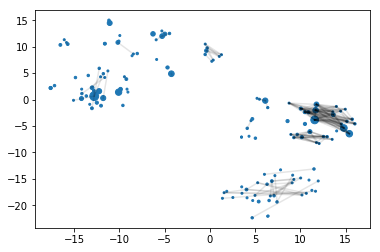

In [159]:
f=cplot(akt, sfactor= 2, alpha =.1)

### 4.1 Adding activity data

In [161]:
aktact = akt["cores"].groupby("MID").PCHEMBL_VALUE.apply(lambda x: - np.log10(np.median([10 ** - y for y in x])))
aktact = pd.DataFrame({"MID": aktact.index, "act": aktact.values})
akt["chemspace"] = akt["chemspace"].merge(aktact, on="MID")

In [162]:
akt["chemspace"].head()

,core,series_size,xtsne,ytsne,MID,ASID,newASID,act
0,NC1(c2ccc(-c3nc4ccccn4c3-c3ccccc3)cc2)CCC1,39,-12.779179,0.649087,M406,AS10,1,6.870000
1,Nc1ccc2nc(-c3ccc(C4(N)CCC4)cc3)c(-c3ccccc3)n2c1,4,-12.817121,1.668880,M161,AS10,1,6.504971
2,NC1(c2ccc(-c3cn4ccccc4n3)cc2)CCC1,3,-11.771204,4.892986,M1636,AS10,1,6.870000
3,NC1(c2ccc(-c3nc4cc(OCC=O)ccn4c3-c3ccccc3)cc2)CCC1,2,-15.067787,-0.134503,M808,AS10,1,7.048161
4,c1ccc(-c2cc3cncnc3nc2-c2ccc(CN3CCC(c4nnc[nH]4)...,30,11.572829,-3.836676,M57,AS22,2,7.140000


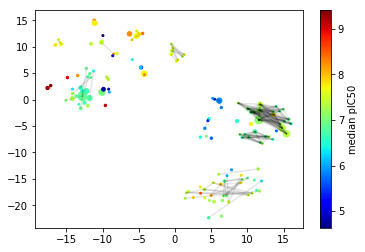

In [163]:
f,o=cplot(akt, sfactor= 2, alpha =.1, col="act", collabel="median pIC50")#plotting with activity

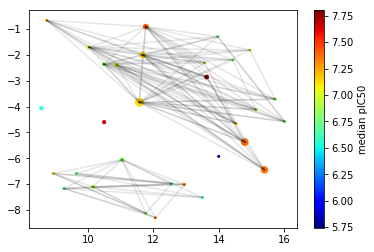

In [202]:
f,o=cplot(akt, sfactor= 2, alpha =.1, col="act", collabel="median pIC50", zoom=(6.5, 20, -13, 5))#applying a zoom

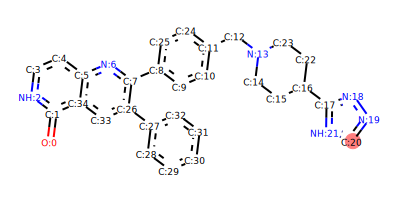

In [233]:
#showing an exemplary core: M1164
m = "M1164"
core = akt["chemspace"].core[akt["chemspace"].MID == m].values[0]
analogs = akt["cores"].washed[akt["cores"].MID == m]
analogs.index = akt["cores"].WID[akt["cores"].MID == m]

Rcore(core, analogs)[0]